# AMEX DEFAULT

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)

#Generic libraryies
import random
import math
import itertools

#Time and monitoring libraries
import time
from tqdm import tqdm
import pyprind

#Visual libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
labels = pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv")

In [3]:
labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [4]:
labels.tail()

,customer_ID,target
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1
458912,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,0


In [5]:
labels.shape

(458913, 2)

In [6]:
#This is to take a rows divider and load data in chunks.
for n in range(10,int(math.sqrt(len(labels)))):
    if len(labels)%n == 0:
        print(n)
        break

13


In [7]:
loadN = int(len(labels)/n)
for i in tqdm(range(1,n+1)):
    if i != 1 and i != n+1:
        skiprows = loadN*(i-1)
        df = df.append(pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv",  header = None, skiprows=skiprows , nrows=loadN, names=cols), ignore_index = True)
    elif i == n+1:
        skiprows = loadN*(i-1)
        df = df.append(pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv",  header = None, skiprows=skiprows , nrows=loadN+1, names=cols), ignore_index = True)
        
    else:
        df = pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv",nrows=loadN)
        cols = df.columns
print("Load complete:", len(df) == len(labels) )

100%|██████████| 13/13 [00:58<00:00,  4.50s/it]

Load complete: True


In [8]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

In [9]:
df.tail()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
458908,1551c34606cba37f85f1d7f0a680a8dc14bc289c405cab...,2018-01-10,0.709743,0.006866,0.007037,0.814817,0.002349,0.169447,0.001700,0.007822,NaN,0.121680,0.005230,0.103418,0.278381,0.002505,0.009063,0.447771,0.349640,0.281959,NaN,0.017907,0.261047,0.002478,0.098289,0.001059,0.000415,0.108319,0.134629,0.624298,0.069105,NaN,0.003773,0.002521,0.007951,1.006145,0.008561,0.112692,0.011063,0.002441,0.436473,NaN,0.004489,0.008356,0.295083,NaN,0.006438,0.543440,0.006794,0.512679,0.007669,0.289784,0.013366,CO,O,0.003025,0.004467,NaN,0.585226,0.007861,NaN,0.001479,6.0,0.188647,0.006253,0.001335,0.003094,0.007371,0.001399,0.007897,0.013998,0.006187,0.501448,0.224684,NaN,0.007112,0.150375,0.136658,NaN,0.006565,0.009422,NaN,0.003414,0.000371,0.009569,0.001288,0.002584,NaN,0.007577,0.004596,0.006070,0.003211,0.004657,0.004638,NaN,0.009325,1.005157,0.097731,0.002076,0.008381,0.005351,0.006517,0.001387,0.004646,NaN,0.0,0.004499,0.006044,NaN,0.004832,0.000377,NaN,1,0.003909,0.006880,0.004190,0.009986,0.006743,0.004722,1.001116,0.008855,0.003740,0.000658,0.005029,0.007454,0.008030,0.001389,0.007140,0.009009,0.007241,0.295984,0.132780,0.081658,0.974536,0.003206,0.200196,1.009875,0.965023,0.226399,NaN,0.340511,0.006401,0.005547,NaN,1.006769,1.0,NaN,0.006377,NaN,NaN,NaN,1.001665,0.243995,NaN,0.008831,1.0,0.237347,0.0,4.0,0.239652,0.234983,0.0,0.500854,0.573047,0.004625,0.369872,0.003406,1.0,0.001629,1.005343,1.008627,0.006326,NaN,0.007654,0.003839,NaN,0.007221,0.000735,NaN,NaN,NaN,NaN,NaN,0.003901,0.001431,0.005963,NaN,0.004385,0.003285,0.008823
458909,1551c34606cba37f85f1d7f0a680a8dc14bc289c405cab...,2018-02-07,0.686646,0.005216,0.003897,0.812582,0.003066,NaN,0.003037,0.009129,NaN,0.110840,0.008148,0.109205,0.280172,0.008722,0.001717,0.442767,0.360812,0.314718,NaN,0.017220,0.239044,0.001758,0.088103,0.002567,0.001826,0.102424,0.131292,0.619958,0.057567,NaN,0.002991,0.004921,1.001920,1.008702,0.005381,NaN,0.010853,0.006784,0.418988,NaN,0.005849,0.006257,0.281052,NaN,0.003487,0.550338,0.002074,0.501911,0.003329,0.281369,0.056801,CO,O,0.000297,0.003126,NaN,0.646309,0.009719,NaN,0.002263,6.0,0.189994,0.008955,0.008206,0.002783,0.003207,0.001850,0.009437,0.012674,0.004148,0.508168,0.204465,NaN,0.006760,0.151750,0.141131,NaN,0.006442,0.009665,0.058195,0.009618,0.003446,0.004635,0.006681,0.003395,NaN,0.006231,0.000137,0.003978,0.008877,0.004598,0.007713,NaN,0.001835,1.007484,0.091374,0.005171,0.006132,0.001257,0.003988,0.003244,0.003635,NaN,0.0,0.002484,0.008243,NaN,0.009553,0.004113,NaN,1,0.008221,0.005840,0.009080,0.009340,0.006395,0.001065,1.006277,0.008582,0.002762,0.006765,0.009935,0.009672,0.004055,0.008596,0.001178,0.000671,0.003719,0.297294,0.140381,0.082426,0.974965,0.005581,0.229398,1.006564,0.966744,0.238342,NaN,0.339251,0.001064,0.005243,NaN,1.006653,1.0,NaN,0.006206,NaN,NaN,NaN,1.009739,0.214825,NaN,0.003289,1.0,0.238845,0.0,4.0,0.232850,0.231477,0.0,0.501396,0.579796,0.003468,0.371480,0.000976,1.0,0.005212,1.007951,1.006834,0.005095,NaN,0.008248,0.008105,NaN,0.007209,0.005437,NaN,NaN,N

# Target feature

First we will see the target's distribution.

In [10]:
labels.groupby("target").count()*100/len(labels)

,customer_ID
target,
0,74.106639
1,25.893361


Its 74% non-default vs 26% default. It isn't very unbalanced.

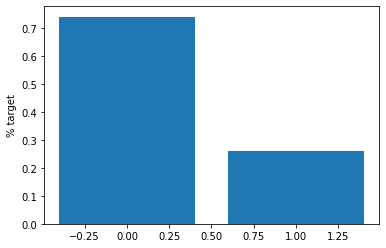

In [11]:
aux = labels.target.value_counts()/len(labels)
plt.bar(x = [0,1], height = [aux.iloc[0], aux.iloc[1]])
plt.ylabel('% target')
plt.show()

# Train EDA

First we are goint to analize numeric columns, because probably we must do aggregations and later these will be categorical.

**We must keep in mind that:**
* D_* = Delinquency variables
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables

In [12]:
dims = df.shape
print("We have", dims[0] , "rows and", dims[1], "columns.")

We have 458913 rows and 190 columns.


In [13]:
dropCols = []

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 665.2+ MB


In [15]:
print(f"There are {df.select_dtypes('object').shape[1]} object columns \nThere are {df.select_dtypes('int').shape[1]} int columns\nThere are {df.select_dtypes('float').shape[1]} float columns")

There are 4 object columns 
There are 1 int columns
There are 185 float columns


In [16]:
categorical = []
integer = []
floats = []

for col in tqdm(df.columns):
    if df[col].dtype == 'O':
        categorical.append(col)
    elif df[col].dtype == 'float':
        floats.append(col)
    else:
        integer.append(col)

100%|██████████| 190/190 [00:00<00:00, 25866.39it/s]


### Drop columns duplicates

In [17]:
%time df = df.T.drop_duplicates().T

CPU times: user 11min 39s, sys: 10.5 s, total: 11min 50s
Wall time: 11min 49s


In [18]:
for col in tqdm(df.columns):
    if col in integer:
        df[col] = pd.to_numeric(df[col])
    elif col in floats:
        df[col] = pd.to_numeric(df[col])

100%|██████████| 190/190 [01:50<00:00,  1.71it/s]


In [19]:
print(f"There are {df.select_dtypes('object').shape[1]} object columns \nThere are {df.select_dtypes('int').shape[1]} int columns\nThere are {df.select_dtypes('float').shape[1]} float columns")

There are 4 object columns 
There are 1 int columns
There are 185 float columns


### Integer columns

In [20]:
df.select_dtypes('int').nunique().sort_values().to_frame().T

,B_31
0,2


In [21]:
print(df["B_31"].unique())
print(df["B_31"].sum()*100/len(df) ,"are the same values, this column seem that hasn't got info.")

dropCols.append("B_31")

[1 0]
99.71192796891786 are the same values, this column seem that hasn't got info.


### Float columns

In [22]:
floatsAux = df.select_dtypes('float').nunique().sort_values().to_frame().T *100/len(df)
print("Columns with less than 5% distinct values, probably are not useless, we are going to analice and compare with other partitions. Then we will decide if this columns will be deleted.")

floatsAux = floatsAux[floatsAux <= 5 ].dropna(axis =1)
for col in floatsAux.columns.values:
    dropCols.append(col)
    
    
floatsAux

Columns with less than 5% distinct values, probably are not useless, we are going to analice and compare with other partitions. Then we will decide if this columns will be deleted.


,D_87,D_120,D_66,D_116,D_114,D_126,B_30,D_117,B_38,D_68,D_88,D_108,D_111,D_110,B_39,D_73,B_42,D_138,D_134,D_137,D_136,D_135
0,0.000218,0.000436,0.000436,0.000436,0.000436,0.000654,0.000654,0.001525,0.001525,0.001525,0.119195,0.527987,0.607087,0.607087,0.650232,1.005201,1.221582,3.5364,3.5364,3.5364,3.5364,3.5364


### Categorical columns

In [23]:
df.select_dtypes('O').nunique().sort_values().to_frame().T

,D_64,D_63,S_2,customer_ID
0,4,6,396,38024


In [24]:
df.groupby("D_64").count()["customer_ID"]*100/len(df)

D_64
-1     0.654372
O     52.866665
R     15.005241
U     27.522864
Name: customer_ID, dtype: float64

In [25]:
df.groupby("D_63").count()["customer_ID"]*100/len(df)

D_63
CL     7.891474
CO    74.401902
CR    16.905165
XL     0.122681
XM     0.189578
XZ     0.489199
Name: customer_ID, dtype: float64

In [26]:
train = labels.merge(df, on = ["customer_ID"], how = "left")

### ¿Drop columns?

In [27]:
train[dropCols]

,B_31,D_87,D_120,D_66,D_116,D_114,D_126,B_30,D_117,B_38,D_68,D_88,D_108,D_111,D_110,B_39,D_73,B_42,D_138,D_134,D_137,D_136,D_135
0,1.0,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### B_31

In [28]:
df["B_31"].value_counts()

1    457591
0      1322
Name: B_31, dtype: int64

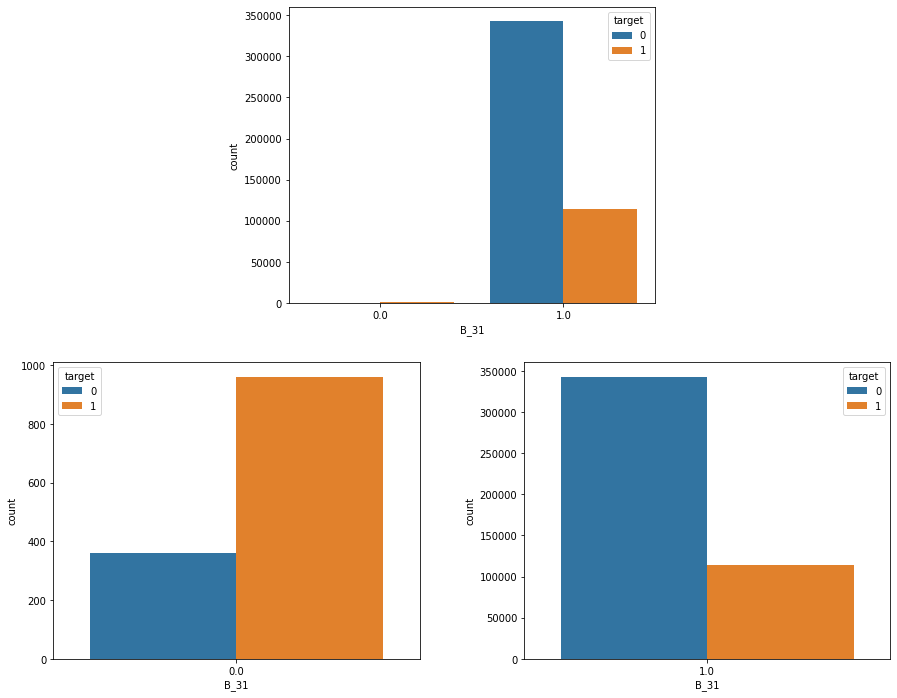

In [29]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(2, 4, figure = fig)
gs.update(wspace=0.8 )

ax1 = plt.subplot(gs[1, :2], )
sns.countplot(data = train[train["B_31"] == 0][[dropCols[0], "target"]] , x = "B_31", hue = "target", ax=ax1)

ax2 = plt.subplot(gs[1, 2:])
sns.countplot(data = train[train["B_31"] == 1][[dropCols[0], "target"]] , x = "B_31", hue = "target" , ax=ax2)

ax3 = plt.subplot(gs[0, 1:3])
sns.countplot(data = train[[dropCols[0], "target"]] , x = "B_31", hue = "target", ax=ax3)

plt.show()